In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/tomato-dataset-full/data/labeled-data/riped/riped_tomato_74.jpeg
/kaggle/input/tomato-dataset-full/data/labeled-data/riped/riped_tomato_64.jpeg
/kaggle/input/tomato-dataset-full/data/labeled-data/riped/riped_tomato_60.jpeg
/kaggle/input/tomato-dataset-full/data/labeled-data/riped/riped_tomato_22.jpeg
/kaggle/input/tomato-dataset-full/data/labeled-data/riped/riped_tomato_7.jpeg
/kaggle/input/tomato-dataset-full/data/labeled-data/riped/riped_tomato_85.jpeg
/kaggle/input/tomato-dataset-full/data/labeled-data/riped/riped_tomato_49.jpeg
/kaggle/input/tomato-dataset-full/data/labeled-data/riped/riped_tomato_50.jpeg
/kaggle/input/tomato-dataset-full/data/labeled-data/riped/riped_tomato_79.jpeg
/kaggle/input/tomato-dataset-full/data/labeled-data/riped/riped_tomato_89.jpeg
/kaggle/input/tomato-dataset-full/data/labeled-data/riped/riped_tomato_97.jpeg
/kaggle/input/tomato-dataset-full/data/labeled-data/riped/riped_tomato_58.jpeg
/kaggle/input/tomato-dataset-full/data/labeled-data/r

# SSL Method - FixMatch to predict ripeness of tomatoes
- ResNet
- Dropout
- L2 Regularization
- Learning Rate Scheduler

In [2]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Dataset
from copy import deepcopy
from tqdm import tqdm
from PIL import Image
from torchvision.transforms import RandAugment

In [3]:
seed = 1

# Set device to use GPU if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
else: 
    device = torch.device('cpu')

torch.manual_seed(seed)

print(device)

cuda


In [4]:
# Enforce deterministic algorithms
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
# DataLoader with worker_init_fn to ensure different seeds for each worker
def worker_init_fn(worker_id):
    np.random.seed(seed + worker_id)
    random.seed(seed + worker_id)
    torch.manual_seed(seed + worker_id)

## Data Setup

In [6]:
# Define transformations
transform_weak = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_strong = transforms.Compose([
    transforms.Resize((224, 224)),
    RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
# Load labeled datasets
labeled_data_dir = '/kaggle/input/tomato-dataset-full/data/labeled-data'
labeled_dataset = datasets.ImageFolder(labeled_data_dir, transform=transform_weak)

In [8]:
# Split labeled data into training and testing datasets
train_size = int(0.8 * len(labeled_dataset))
test_size = len(labeled_dataset) - train_size
train_dataset, test_dataset = random_split(labeled_dataset, [train_size, test_size])

In [9]:
# Define dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, worker_init_fn=worker_init_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, worker_init_fn=worker_init_fn)

print('Num Labeled: ', len(labeled_dataset))

Num Labeled:  177


In [10]:
# Custom dataset class for unlabeled data
class UnlabeledDataset(Dataset):
    def __init__(self, data_dir, transform_weak=None, transform_strong=None):
        self.data_dir = data_dir
        self.transform_weak = transform_weak
        self.transform_strong = transform_strong
        self.image_paths = [os.path.join(data_dir, img) for img in os.listdir(data_dir) if img.endswith('.jpg') or img.endswith('.png')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform_weak:
            weak_image = self.transform_weak(image)
        if self.transform_strong:
            strong_image = self.transform_strong(image)
        return weak_image, strong_image

In [11]:
# Load unlabeled datasets
unlabeled_data_dir = '/kaggle/input/tomato-dataset-full/data/unlabeled-data'
unlabeled_dataset = UnlabeledDataset(unlabeled_data_dir, transform_weak=transform_weak, transform_strong=transform_strong)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=16, shuffle=True, num_workers=4, worker_init_fn=worker_init_fn)

print('Num Unlabeled: ', len(unlabeled_dataset))

Num Unlabeled:  996


## Define Model

In [12]:
# Define the ResNet model with dropout
class ResNetModel(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNetModel, self).__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [13]:
# Initialize the model
model = ResNetModel(num_classes=2).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 142MB/s] 


## Train Model

In [14]:
def fixmatch_train(model, train_loader, unlabeled_loader, test_loader, criterion, optimizer, scheduler, num_epochs=35, threshold=0.95):
    best_model_wts = deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    train_accuracy = torchmetrics.Accuracy(task='binary').to(device)
    test_accuracy = torchmetrics.Accuracy(task='binary').to(device)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        
        # Training phase
        model.train()
        running_loss = 0.0
        train_accuracy.reset()
        
        labeled_iter = iter(train_loader)
        unlabeled_iter = iter(unlabeled_loader)
        
        for i in range(len(train_loader)):
            try:
                labeled_inputs, labeled_labels = next(labeled_iter)
            except StopIteration:
                break

            try:
                weak_inputs, strong_inputs = next(unlabeled_iter)
            except StopIteration:
                unlabeled_iter = iter(unlabeled_loader)
                weak_inputs, strong_inputs = next(unlabeled_iter)

            labeled_inputs, labeled_labels = labeled_inputs.to(device), labeled_labels.to(device)
            weak_inputs, strong_inputs = weak_inputs.to(device), strong_inputs.to(device)

            # Forward pass for labeled data
            optimizer.zero_grad()
            labeled_outputs = model(labeled_inputs)
            labeled_loss = criterion(labeled_outputs, labeled_labels)

            # Forward pass for weakly augmented unlabeled data
            with torch.no_grad():
                weak_outputs = model(weak_inputs)
                weak_probs = torch.softmax(weak_outputs, dim=1)
                max_probs, pseudo_labels = torch.max(weak_probs, dim=1)
                mask = max_probs.ge(threshold).float()

            # Forward pass for strongly augmented unlabeled data
            strong_outputs = model(strong_inputs)
            consistency_loss = (nn.CrossEntropyLoss(reduction='none')(strong_outputs, pseudo_labels) * mask).mean()

            # Total loss
            loss = labeled_loss + consistency_loss

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update training metrics
            preds = torch.argmax(labeled_outputs, dim=1)
            train_accuracy.update(preds, labeled_labels)
            running_loss += loss.item() * labeled_inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = train_accuracy.compute().item()
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        test_accuracy.reset()
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc='Validation', leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                preds = torch.argmax(outputs, dim=1)
                test_accuracy.update(preds, labels)
                running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(test_loader.dataset)
        epoch_acc = test_accuracy.compute().item()
        test_losses.append(epoch_loss)
        test_accuracies.append(epoch_acc)
        print(f'Validation Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        scheduler.step()

        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model, train_losses, test_losses, train_accuracies, test_accuracies

In [15]:
# Instantiate model, loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Add L2 regularization
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [16]:
# Train and evaluate the model using FixMatch method
fixmatch_model, train_losses, test_losses, train_accuracies, test_accuracies = fixmatch_train(
    model, train_loader, unlabeled_loader, test_loader, criterion, optimizer, scheduler)

Epoch 1/35
Training Loss: 0.8097 Acc: 0.8014


Validation Loss: 0.2326 Acc: 0.8889
Epoch 2/35


Training Loss: 0.2345 Acc: 0.9362


Validation Loss: 0.6392 Acc: 0.9167
Epoch 3/35


Training Loss: 0.3499 Acc: 0.9504


Validation Loss: 0.0006 Acc: 1.0000
Epoch 4/35


Training Loss: 0.1937 Acc: 0.9504


Validation Loss: 0.0017 Acc: 1.0000
Epoch 5/35


Training Loss: 0.2332 Acc: 0.9433


Validation Loss: 0.2561 Acc: 0.9722
Epoch 6/35


Training Loss: 0.2667 Acc: 0.9362


Validation Loss: 0.0004 Acc: 1.0000
Epoch 7/35


Training Loss: 0.1774 Acc: 0.9504


Validation Loss: 0.0049 Acc: 1.0000
Epoch 8/35


Training Loss: 0.0941 Acc: 0.9645


Validation Loss: 0.0049 Acc: 1.0000
Epoch 9/35


Training Loss: 0.1444 Acc: 0.9716


Validation Loss: 0.0061 Acc: 1.0000
Epoch 10/35


Training Loss: 0.2267 Acc: 0.9362


Validation Loss: 0.0318 Acc: 1.0000
Epoch 11/35


Training Loss: 0.1418 Acc: 0.9787


Validation Loss: 0.0114 Acc: 1.0000
Epoch 12/35


Training Loss: 0.0924 Acc: 0.9858


Validation Loss: 0.0079 Acc: 1.0000
Epoch 13/35


Training Loss: 0.1320 Acc: 0.9858


Validation Loss: 0.0052 Acc: 1.0000
Epoch 14/35


Training Loss: 0.0716 Acc: 0.9858


Validation Loss: 0.0037 Acc: 1.0000
Epoch 15/35


Training Loss: 0.0557 Acc: 0.9858


Validation Loss: 0.0035 Acc: 1.0000
Epoch 16/35


Training Loss: 0.0841 Acc: 0.9787


Validation Loss: 0.0031 Acc: 1.0000
Epoch 17/35


Training Loss: 0.0640 Acc: 0.9858


Validation Loss: 0.0034 Acc: 1.0000
Epoch 18/35


Training Loss: 0.0483 Acc: 0.9858


Validation Loss: 0.0024 Acc: 1.0000
Epoch 19/35


Training Loss: 0.0649 Acc: 0.9787


Validation Loss: 0.0059 Acc: 1.0000
Epoch 20/35


Training Loss: 0.0606 Acc: 0.9929


Validation Loss: 0.0020 Acc: 1.0000
Epoch 21/35


Training Loss: 0.0647 Acc: 0.9787


Validation Loss: 0.0022 Acc: 1.0000
Epoch 22/35


Training Loss: 0.0641 Acc: 0.9787


Validation Loss: 0.0013 Acc: 1.0000
Epoch 23/35


Training Loss: 0.0705 Acc: 0.9716


Validation Loss: 0.0023 Acc: 1.0000
Epoch 24/35


Training Loss: 0.0785 Acc: 0.9716


Validation Loss: 0.0035 Acc: 1.0000
Epoch 25/35


Training Loss: 0.0435 Acc: 0.9858


Validation Loss: 0.0020 Acc: 1.0000
Epoch 26/35


Training Loss: 0.0569 Acc: 0.9858


Validation Loss: 0.0032 Acc: 1.0000
Epoch 27/35


Training Loss: 0.1294 Acc: 0.9716


Validation Loss: 0.0027 Acc: 1.0000
Epoch 28/35


Training Loss: 0.0518 Acc: 0.9787


Validation Loss: 0.0021 Acc: 1.0000
Epoch 29/35


Training Loss: 0.0688 Acc: 0.9929


Validation Loss: 0.0024 Acc: 1.0000
Epoch 30/35


Training Loss: 0.0669 Acc: 0.9787


Validation Loss: 0.0020 Acc: 1.0000
Epoch 31/35


Training Loss: 0.0698 Acc: 0.9858


Validation Loss: 0.0026 Acc: 1.0000
Epoch 32/35


Training Loss: 0.0422 Acc: 0.9929


Validation Loss: 0.0025 Acc: 1.0000
Epoch 33/35


Training Loss: 0.0499 Acc: 0.9858


Validation Loss: 0.0025 Acc: 1.0000
Epoch 34/35


Training Loss: 0.0438 Acc: 1.0000


Validation Loss: 0.0026 Acc: 1.0000
Epoch 35/35


Training Loss: 0.0705 Acc: 0.9858


Validation Loss: 0.0021 Acc: 1.0000


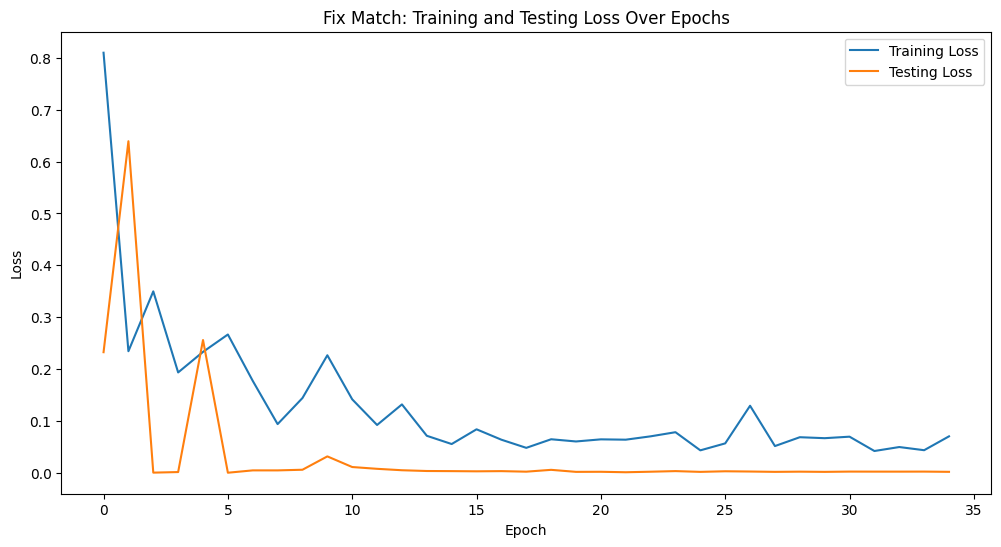

In [17]:
# Plot training and testing loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Fix Match: Training and Testing Loss Over Epochs')
plt.show()

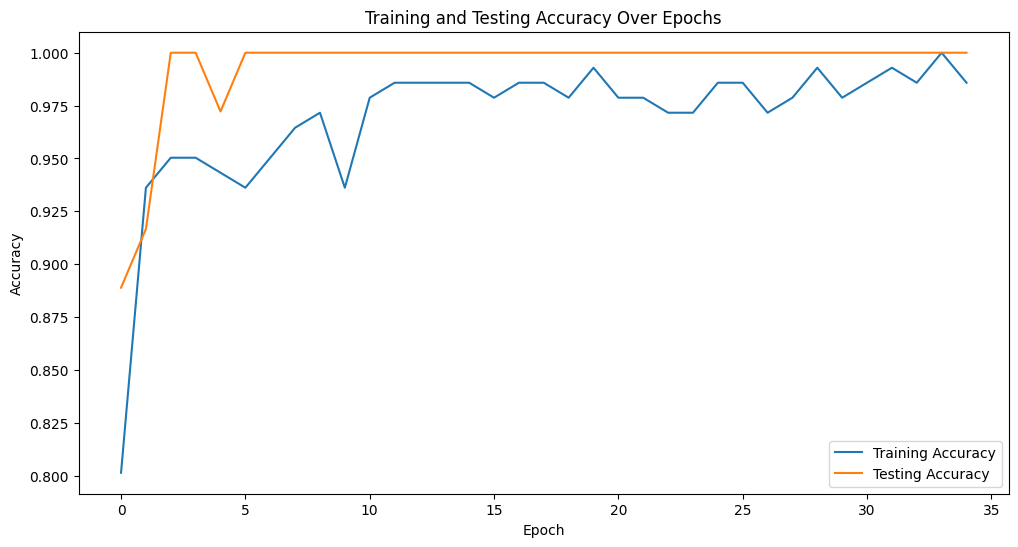

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy Over Epochs')
plt.show()

## Validate

In [19]:
# Evaluate on validation set
validation_dir = '/kaggle/input/tomato-dataset-full/data/validation-data'
validation_dataset = datasets.ImageFolder(validation_dir, transform=transform_val)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False, num_workers=4, worker_init_fn=worker_init_fn)

print('Validation Dataset Size: ', len(validation_dataset))

Validation Dataset Size:  2000


In [20]:
# Evaluate on validation set and display images
def evaluate_and_display(model, validation_loader, num_images=16):
    model.eval()
    val_accuracy = torchmetrics.Accuracy(task='binary').to(device)
    all_labels, all_preds, all_probs = [], [], []
    images = []
    num_samples = 0

    with torch.no_grad():
        for inputs, labels in tqdm(validation_loader, desc='Evaluating', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            val_accuracy.update(preds, labels)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            images.extend(inputs.cpu())
            num_samples += len(labels)

    val_acc = val_accuracy.compute().item()
    print(f'Validation Accuracy: {val_acc:.4f}')
    print(f'Number of samples validated on: {num_samples}')

    # Display images
    def unnormalize(img):
        mean = torch.tensor([0.485, 0.456, 0.406]).to(img.device)
        std = torch.tensor([0.229, 0.224, 0.225]).to(img.device)
        img = img * std[:, None, None] + mean[:, None, None]
        return img

    # Ensure num_images is not larger than the number of images
    if num_images > len(images):
        print(f"Batch size is smaller than num_images. Displaying {len(images)} images instead.")
        num_images = len(images)

    indices = random.sample(range(len(images)), num_images)
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.flatten()

    for ax, idx in zip(axes, indices):
        img = unnormalize(images[idx]).permute(1, 2, 0).numpy()
        ax.imshow(img)
        pred_class = "Riped" if all_preds[idx] == 0 else "Unriped"
        true_class = "Riped" if all_labels[idx] == 0 else "Unriped"
        confidence = np.max(all_probs[idx])
        ax.set_title(f'Predicted: {pred_class} ({confidence:.2f})\nActual: {true_class}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

Validation Accuracy: 0.9500
Number of samples validated on: 2000


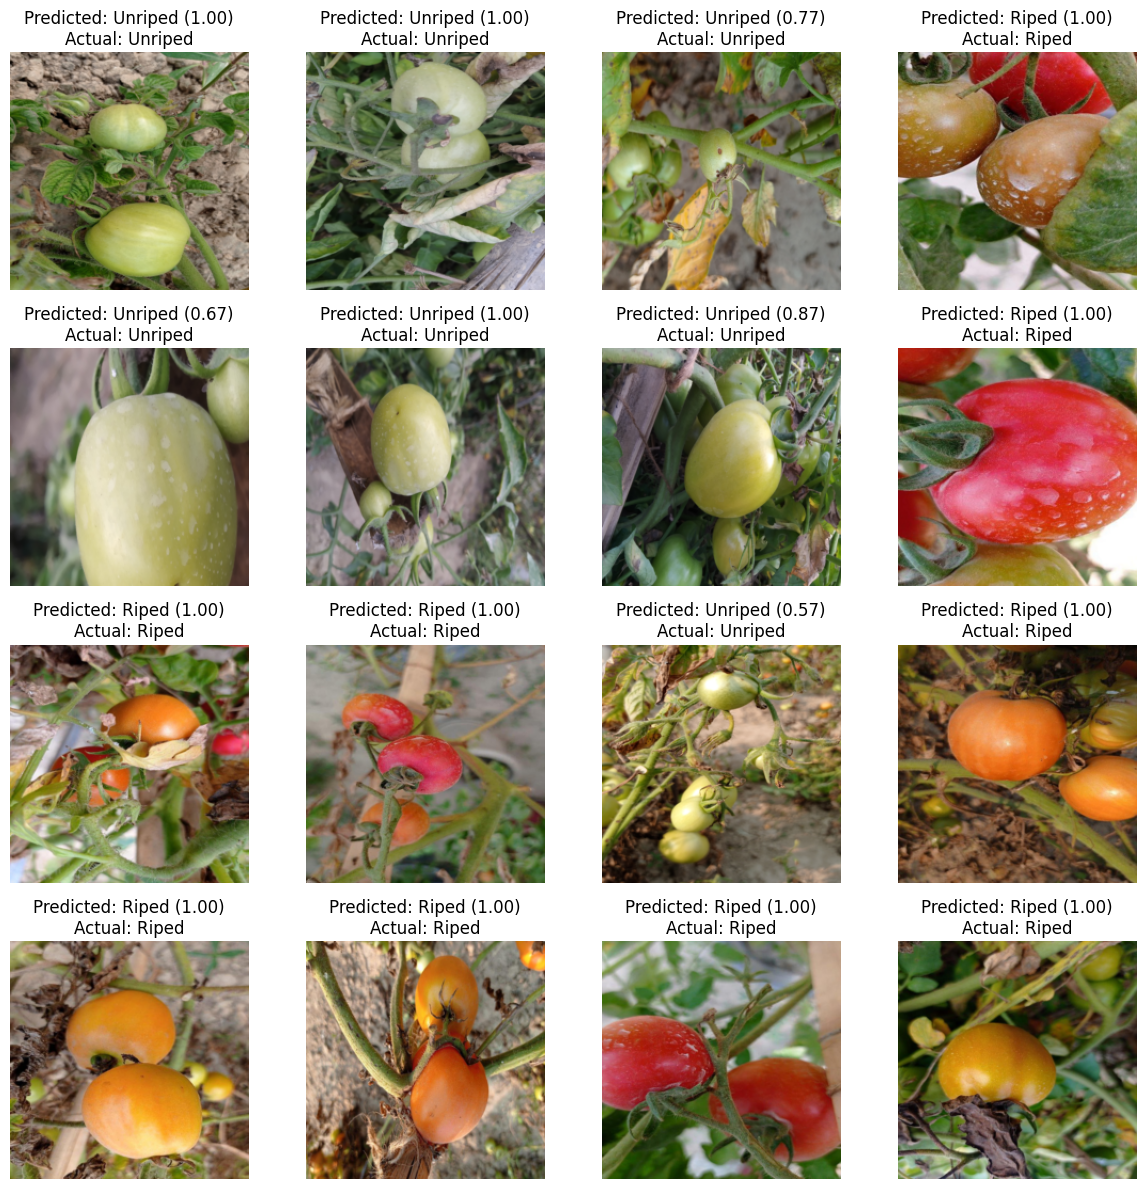

In [21]:
# Evaluate and display
evaluate_and_display(fixmatch_model, validation_loader)